In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(1)
tf.set_random_seed(1)

Objective: See how well LSTM do in forecasting the sin function. The objective is to take the previous n values to predict the n+1 value.

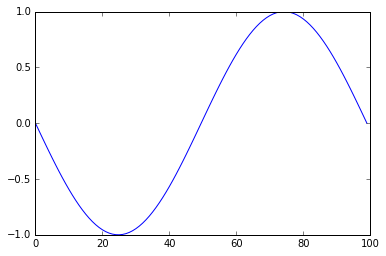

In [3]:
x = np.linspace(-np.pi, np.pi, 100)
sin = np.sin(x)
plt.plot(sin)

60000


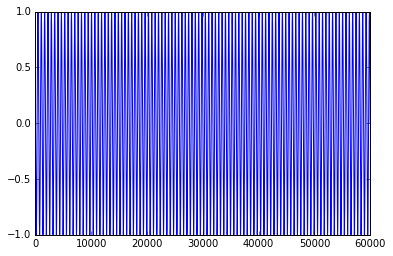

In [4]:

x = np.linspace(-np.pi, np.pi, 600)
sin_data_set = []

for step in range(100):
    for pt in x:
        sin_data_set.append(np.sin(pt))

plt.plot(np.array(sin_data_set))
print(len(sin_data_set))

In [5]:
# Sequence length

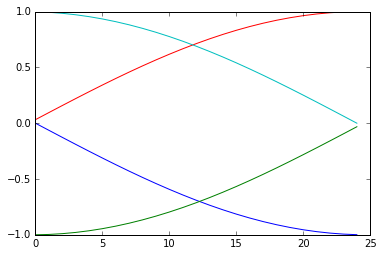

In [6]:
# Sequence lenth of 25
plt.plot(sin[:25])
plt.plot(sin[25:50])
plt.plot(sin[50:75])
plt.plot(sin[75:100])

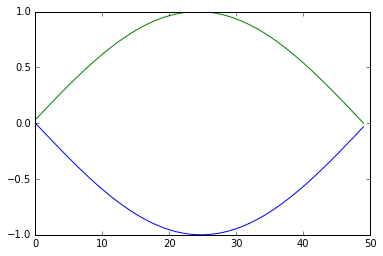

In [7]:
# Sequence lenth of 50
plt.plot(sin[:50])
plt.plot(sin[50:100])

Sequence length of 25 seems like an interesting starting point, as each sequence a decent amount of information in terms of the structure.

In [8]:
def input_fn(data_set, seq_len, batch_size):
    input_seq= []
    target = []
    tot_seq = len(data_set)/seq_len
    for i,seq in enumerate(range(len(data_set)-seq_len-1)):
        input_seq.append(data_set[i:i+seq_len])
        # The target is the next value after seq_len, thus +1
        target.append(data_set[i+seq_len+1])
    
    input_seq = tf.data.Dataset.from_tensor_slices(np.array(input_seq))
    target = tf.data.Dataset.from_tensor_slices(np.array(target))
    dataset = tf.data.Dataset.zip((input_seq, target))
    batched = dataset.batch(batch_size)
    iterator = batched.make_one_shot_iterator()
    return iterator


In [9]:
class LSTM(object):
     
    def __init__(self,
                 sess, 
                 seq_len,
                 n_inputs,
                 n_units,
                 n_layers,
                 n_prediction,
                 keep_prob,
                 batch_size):
        self._sess = sess
        self._seq_len = seq_len           # time step (sequence length)
        self._n_inputs = n_inputs         # size of input
        self._n_units = n_units           # size of hidden layer
        self._n_layers = n_layers         # number of layers
        self._n_prediction = n_prediction # size of prediction
        self._keep_prob = keep_prob       # probability for dropout
        self._batch_size = batch_size     # batch size
        self._is_training = None          # training or not (test = False)
        self._build_graph()          
        
    def _model(self):
        def lstm_cell():
            cell = tf.contrib.rnn.LSTMCell(self._n_units, state_is_tuple=True)
            if self._is_training:
                cell = tf.contrib.rnn.DropoutWrapper(
                    cell,
                    output_keep_prob=self._keep_prob
                )
            return cell
        
        cell = tf.contrib.rnn.MultiRNNCell(
            [lstm_cell() for _ in range(self._n_layers)],
            state_is_tuple=True
        ) if self._n_layers > 1 else self.lstm_cell()
        
        # "out" is of dimension [batch_size, max_time, cell_state_size]
        out, state = tf.nn.dynamic_rnn(cell=cell, inputs=self._inputs, dtype=tf.float32)
        
        # Transpose "out" to dimension [max_time, batch_size, cell_state_size]
        out = tf.transpose(out, [1, 0, 2])
        
        # Assuming self._seq_len = 25 and self._n_units = 50
        # out.get_shape() == (25, ?, 50) after tf.transpose
        # int(out.get_shape()[0]) - 1 == 24 <= gets index of last out, which is 
        # what we want.
        out = tf.gather(out, int(out.get_shape()[0]) - 1)
        fc_w = tf.get_variable("fc_w", shape=[self._n_units, self._n_prediction])
        fc_b = tf.get_variable("fc_b", shape=[self._n_prediction])
        pred = tf.matmul(out,fc_w) + fc_b
        return tf.reshape(pred, [-1, self._n_prediction])
                
    def _build_graph(self):
        # Many to one architecture
        self._inputs = tf.placeholder("float", [None, self._seq_len, self._n_inputs])
        self._target = tf.placeholder("float", [None, self._n_prediction])
        
        self._pred = self._model()
        self._loss = tf.losses.mean_squared_error(labels=self._target, predictions=self._pred)
        self._train = tf.train.AdamOptimizer().minimize(self._loss)        
        
    def train(self, data_set):
        self._is_training = False
        tf.global_variables_initializer().run()
        iterator = input_fn(data_set, self._seq_len, self._batch_size)
        next_element = iterator.get_next()
        step = 0
        epoch_loss = []
        
        # Train on one epoch, consume entire data set.
        while True:
            try:
                batch_sequence, batch_target = self._sess.run(next_element)
                loss, _ = self._sess.run([self._loss, self._train], feed_dict={
                    self._inputs: batch_sequence.reshape(-1, self._seq_len, 1), 
                    self._target: batch_target.reshape(-1,1)}
                )
                epoch_loss.append(loss)
                step+=1
                if step%100 == 0:
                    print("Step: {} Loss: {}".format(step, np.mean(epoch_loss)))
            except tf.errors.OutOfRangeError:
                print("End of dataset")
                break
                
    def evaluate(self):
        self._is_training = False
        x = np.linspace(-np.pi, np.pi, 600)
        xs = []
        for step in range(10):
            for pt in x:
                 xs.append(np.sin(pt))
                    
        test_seq = []
        for i,seq in enumerate(range(len(xs)-self._seq_len-1)):
            test_seq.append(xs[i:i+self._seq_len])
        
        test_seq = np.array(test_seq)
        maybe_sin = []
        for seq in test_seq:
            f_x = self._sess.run(self._pred, feed_dict={
                self._inputs: seq.reshape(1, self._seq_len, 1)
            })
            
            maybe_sin.append(f_x[0,0])
            
        # Need to shift by seq_len
        sin = np.array(xs)[self._seq_len+1:]
        plt.plot(maybe_sin, "b")
        plt.plot(sin, "r")
        plt.plot(maybe_sin - sin)
        

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Step: 100 Loss: 0.449271470308
Step: 200 Loss: 0.230466425419
Step: 300 Loss: 0.157050848007
Step: 400 Loss: 0.119832508266
Step: 500 Loss: 0.0970866978168
Step: 600 Loss: 0.0855595320463
Step: 700 Loss: 0.0741891562939
Step: 800 Loss: 0.0654454156756
Step: 900 Loss: 0.058485776186
End of dataset


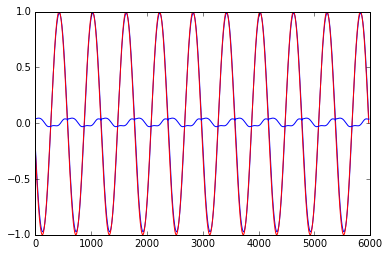

In [10]:
seq_len = 25
n_inputs = 1
n_units = 50
n_layers = 2
n_prediction = 1
keep_prob = 0.8
batch_size = 64

tf.reset_default_graph()
with tf.Session() as sess:
    model = LSTM(sess, seq_len, n_inputs, n_units, n_layers, n_prediction, keep_prob, batch_size)
    model.train(sin_data_set)
    model.evaluate()